# Solucion tarea 3 - Aprendizaje Supervisado

In [1]:
%matplotlib notebook

In [2]:
import os
import time
import sqlite3
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

In [6]:
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

In [7]:
import logging
from logging.handlers import RotatingFileHandler

file_name = 'proc_models'
logger = logging.getLogger()
dir_log = f'data/logs/{file_name}.log'

handler = RotatingFileHandler(dir_log, maxBytes=2000000, backupCount=10)
logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s - %(process)d - %(name)s - %(levelname)s - %(message)s",
                    handlers = [handler])

### Importación y preparación de los datos

In [8]:
conn = sqlite3.connect('data/data_accidentes.sqlite3')

d_ini = dt.datetime(2017,6,1)
d_fin = dt.datetime(2018,1,1)

query = f""" SELECT * FROM
            info
            WHERE
            TW >= '{d_ini}' AND
            TW < '{d_fin}' """
            
data = pd.read_sql_query(query, conn)
data['TW'] = pd.to_datetime(data['TW'])

In [9]:
### Dejar solo accidentes del Poblado
lista_poblado = """
ElGuamal
BarrioColombia
VillaCarlota
Castropol
Lalinde
LasLomasNo1
LasLomasNo2
AltosdelPoblado
ElTesoro
LosNaranjos
LosBalsosNo1
SanLucas
ElDiamanteNo2
ElCastillo
LosBalsosNo2
Alejandria
LaFlorida
ElPoblado
Manila
Astorga
PatioBonito
LaAguacatala
SantaMariadeLosÁngeles
"""
lista_poblado_l = lista_poblado.split('\n')

data = data[data['BARRIO'].isin(lista_poblado_l)]
data['poblado'] = data['BARRIO']
data= pd.get_dummies(data, columns=['poblado'])

In [10]:
### Variables Relevantes
cols = ['apparentTemperature', 'temperature', 'humidity_mean',
       'temperature_mean', 'apparentTemperature_mean', 'humidity',
       'dewPoint_mean', 'dewPoint', 'windSpeed_mean', 'windSpeed',
       'cloudCover_mean', 'uvIndex', 'icon_partly-cloudy-night',
       'poblado_LaAguacatala', 'visibility_mean', 'cloudCover', 'dia_sem_6',
       'precipIntensity_mean', 'visibility', 'poblado_ElCastillo',
       'icon_partly-cloudy-day', 'poblado_VillaCarlota', 'poblado_Astorga',
       'precipIntensity', 'poblado_AltosdelPoblado', 'precipProbability',
       'hora_7', 'poblado_LosBalsosNo1', 'poblado_ElDiamanteNo2',
       'poblado_Manila', 'poblado_SantaMariadeLosÁngeles', 'poblado_Lalinde',
       'hora_3', 'hora_0', 'hora_1', 'dia_sem_4', 'dia_sem_5', 'hora_2',
       'poblado_ElPoblado', 'poblado_SanLucas', 'poblado_LasLomasNo2',
       'dia_sem_1', 'dia_sem_2', 'poblado_BarrioColombia',
       'poblado_LosBalsosNo2', 'hora_19', 'hora_4', 'dia_sem_3', 'dia_sem_0',
       'hora_17', 'hora_6', 'icon_cloudy']

In [11]:
data['Accidente'].sum()

2069.0

In [12]:
### Agregar otras features
data['hora'] = data['TW'].dt.hour
data['dia_sem'] = data['TW'].dt.dayofweek

data= pd.get_dummies(data, columns=['hora'])
data= pd.get_dummies(data, columns=['icon'])
data= pd.get_dummies(data, columns=['dia_sem'])

In [13]:
len(data.columns)

73

In [14]:
### Feature augmentation
freq = '5H'
variables = ['temperature','precipIntensity','apparentTemperature','dewPoint',
             'humidity','windSpeed','cloudCover','visibility']

data_aux = data.copy()
data_aux.index = data_aux.TW
data_aux = data_aux.sort_index()
data_aux = data_aux.drop(columns = 'TW')
resample_data = data_aux[variables].rolling(freq, closed = 'left').mean()

data_pivot = data_aux.pivot_table(values=variables, index='TW',columns='BARRIO', aggfunc=sum)
data_mean = data_pivot.rolling(freq, closed = 'left').mean().stack().reset_index(drop = False)

col_means = [*data_mean.columns[:2]]
for col in data_mean.columns[2:]:
    col_means.append(col + '_mean')
    
data_mean.columns = col_means

data = data.merge(data_mean, how = 'left', on = ['TW','BARRIO'])
data = data.dropna().reset_index(drop = True)

In [15]:
data_train = data[data['TW']<dt.datetime(2017,11,1)].reset_index(drop = True)
data_test = data[data['TW']>=dt.datetime(2017,11,1)].reset_index(drop = True)

In [16]:
X = data_train.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y = data_train['Accidente'].reset_index(drop=True)               # target feature
X = X[X.columns[2:]]
X = X[cols]

In [17]:
X_test = data_test.drop("Accidente", 1).reset_index(drop=True)       # feature matrix 
y_test = data_test['Accidente'].reset_index(drop=True)               # target feature
X_test = X_test[X_test.columns[2:]]
X_test = X_test[cols]

In [18]:
X_train = X.copy()
y_train = y.copy()

In [19]:
tra_0 = int(len(y_train) - y_train.sum())
tra_1 = int(y_train.sum())

prop_deseada_under = 0.4
mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
X_train_under, y_train_under = rus.fit_sample(X_train, y_train)

In [20]:
X_train_under.shape

(3787, 52)

### Entrenamiento y selección de modelos

In [21]:
def grid(base_path, now_date, path_file, X, Y, models, score = 'roc_auc', cv = 2, n_proc = 2, random = False, n_iter = 10):    
    
    for name in models:

        t_ini = time.time()

        pipeline = Pipeline([('scaler', StandardScaler()), (name,  models[name]['mod'])])
        parameters = {}          
        for par in models[name]['par']:
            aux = name + '__' +  par
            parameters[aux] = models[name]['par'][par]
        
        if random:
            mod_aux = RandomizedSearchCV(pipeline, parameters, n_jobs = n_proc,\
                              scoring = score, verbose=1, cv = cv, n_iter = n_iter)
        else:
            mod_aux = GridSearchCV(pipeline, parameters, n_jobs = n_proc,\
                              scoring = score, verbose=1, cv = cv)
                
        mod_aux.fit(X, Y)
        models[name]['bestModel'] = mod_aux.best_estimator_
        models[name]['roc'] = mod_aux.best_score_

        selection_time = time.time() - t_ini

        models[name]['selection_time'] = selection_time

        sample_f_path = os.path.join(base_path, path_file, f'{name}_{now_date.strftime("%Y%m%d_%H%M")}.sav')

        joblib.dump(models[name]['bestModel'], sample_f_path)

        print(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        print(f"El ROC de la familia {name} es: {models[name]['roc']:0.3f}")
        print('*'*80)
        
        logger.info(f"El tiempo de seleccion fue: {selection_time:0.3f} s")
        logger.info(f"El ROC de la familia {name} es: {models[name]['roc']:0.3f}")
        logger.info('*'*80)        
       
    mod_name = None
    best_roc = 0
    for name in models:
        if models[name]['roc'] > best_roc:
            mod_name = name
            best_roc = models[name]['roc']

    print(f"El mejor modelo fue: {mod_name} con un ROC de: {best_roc}")
    
    logger.info(f"El mejor modelo fue: {mod_name} con un ROC de: {best_roc}")
    
    return models, mod_name

### Resultados

In [22]:
modelo_final = {
                     'rforest_final':{
                                'mod': RandomForestClassifier(random_state= 42, bootstrap = True),
                                'par': {'n_estimators':[10,20,30,40,50,60,70,80,90,100,200,300,400,500],
                                        'max_depth': [None, 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70],
                                            'criterion':('gini','entropy')
                                       }
                     }
                 }

In [ ]:
base_path = os.getcwd()
now_date = dt.datetime.now()
path_file = 'data/models'
models, mod_name = grid(base_path, 
                        now_date, 
                        path_file,  
                        X_train_under, 
                        y_train_under, 
                        modelo_final, 
                        score = 'roc_auc', 
                        cv =4 , 
                        n_proc = 11,
                        random = False,
                        n_iter = 20)

El tiempo de seleccion fue: 22.130 s

El ROC de la familia rforest_final es: 0.742

### Desempeno del modelo en el conjunto de prueba

In [23]:
model = joblib.load('data/models/rforest_final_20200226_1915.sav')

In [24]:
model.steps[1]

('rforest_final',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False))

In [25]:
predicciones = model.predict(X_test)
probabilidades = model.predict_proba(X_test)[:,1]

In [26]:
model.steps[1]

('rforest_final',
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='entropy', max_depth=10, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=500,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False))

In [27]:
fscore = f1_score(y_test, predicciones)
roc = roc_auc_score(y_test, probabilidades)
sensibilidad = recall_score(y_test, predicciones)
precision =precision_score(y_test, predicciones)
b_accuracy = balanced_accuracy_score(y_test, predicciones)

print(f'El roc es {roc}')
print(f'La sensibilidad es {sensibilidad}')
print(f'La precision es {precision}')
print(f'El fscore es {fscore}')
print(f'El balanced accuracy es {b_accuracy}')

El roc es 0.7594576244850463
La sensibilidad es 0.5750452079566004
La precision es 0.04757630161579892
El fscore es 0.08788171894431393
El balanced accuracy es 0.6869697687232061


<IPython.core.display.Javascript object>


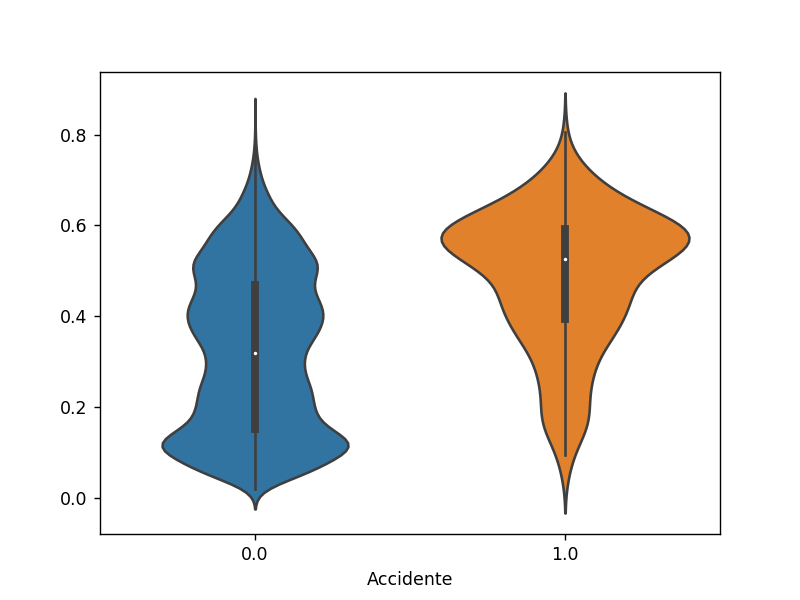

In [28]:
ax = sns.violinplot(x=y_test , y = probabilidades)

<IPython.core.display.Javascript object>


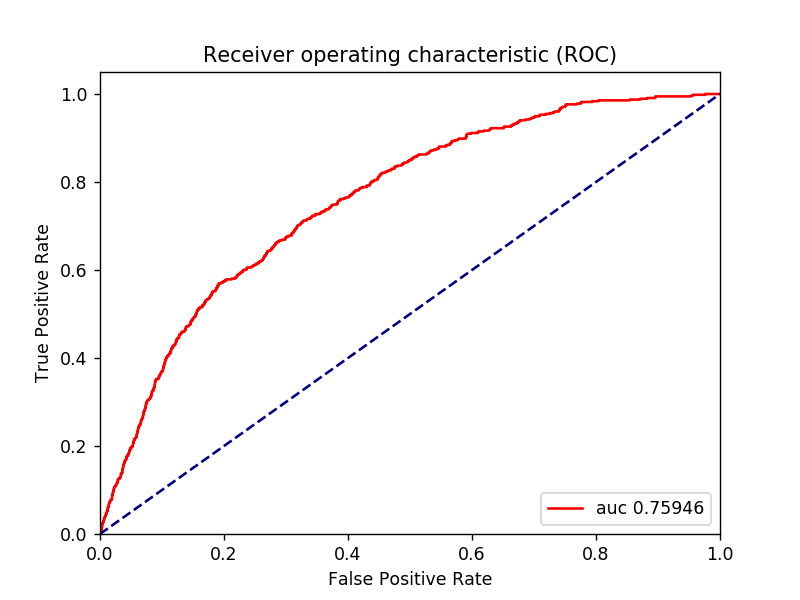

Text(0.5, 1.0, 'Receiver operating characteristic (ROC)')

In [29]:
fig, ax = plt.subplots()  

fpr, tpr, _ = roc_curve(y_test, probabilidades, drop_intermediate=False)
roc_auc = roc_auc_score(y_test, probabilidades)

ax.plot(fpr, tpr, color='red', label=f'auc %0.5f' % roc_auc)    
ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
ax.legend(loc="lower right")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')    
ax.set_title('Receiver operating characteristic (ROC)')

## Analisis de Sensibilidad 

Modelo: Random Forest

In [30]:
X_train1, X_val, y_train1, y_val = train_test_split(X, y, stratify=y, test_size=0.2)

tra_0 = int(len(y_train1) - y_train1.sum())
tra_1 = int(y_train1.sum())

prop_deseada_under = 0.5
mul_updown = (tra_0 * prop_deseada_under - tra_1 * (1 - prop_deseada_under)) / (tra_0 * prop_deseada_under)   
fac_1 = int(tra_0 * (1 - mul_updown))

ratio_u = {0 : fac_1, 1 : tra_1}
rus = RandomUnderSampler(sampling_strategy = ratio_u, random_state=42)
X_train_under1, y_train_under1 = rus.fit_sample(X_train1, y_train1)

In [31]:
times = []
rocs = []
n_estimators = [10,20,30,40,50,60,70,80,90,100, 110, 120, 140, 150, 160, 170, 180, 190,200, 210, 
                220, 240, 250, 260, 270, 280, 290,  300,310, 320, 330, 340, 350, 360, 370, 380, 
                390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]
for n in n_estimators:
    
    clf = RandomForestClassifier(n_estimators = n, random_state= 42, bootstrap = True)
    
    start = time.time()
    clf.fit(X_train_under1, y_train_under1)
    times.append(time.time() - start)
    
    preds = clf.predict_proba(X_val)[:,1]
    
    rocs.append(roc_auc_score(y_val, preds))

<IPython.core.display.Javascript object>


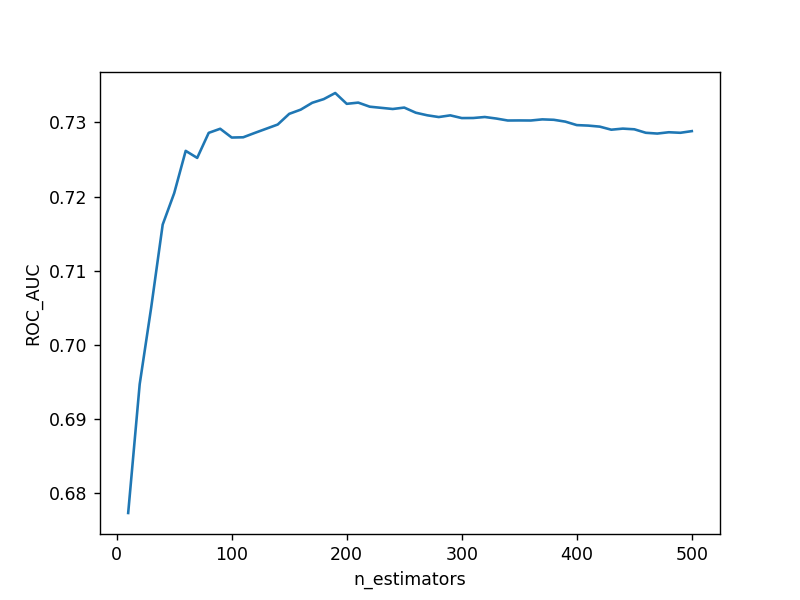

Text(0, 0.5, 'ROC_AUC')

In [32]:
ax = plt.figure('roc vs Tiempo Computo - n_estimators')
plt.plot(n_estimators,rocs)
plt.xlabel('n_estimators')
plt.ylabel('ROC_AUC')

<IPython.core.display.Javascript object>


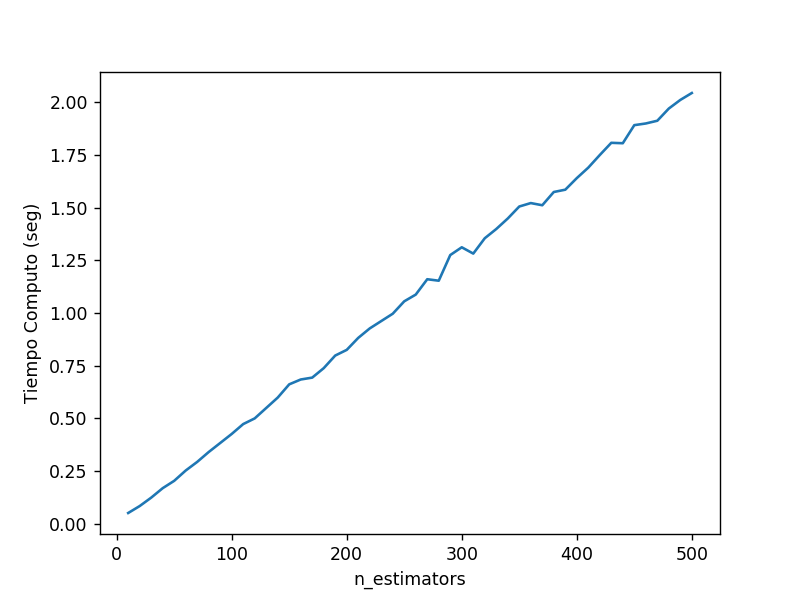

Text(0, 0.5, 'Tiempo Computo (seg)')

In [33]:
ax = plt.figure('n_estimators vs Tiempo Computo')
plt.plot(n_estimators,times)
plt.xlabel('n_estimators')
plt.ylabel('Tiempo Computo (seg)')

In [34]:
times2 = []
rocs2 = []
max_depth = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
for max_d in max_depth:
    
    clf = RandomForestClassifier(max_depth = max_d, random_state= 42, bootstrap = True)
    
    start = time.time()
    clf.fit(X_train_under1, y_train_under1)
    times2.append(time.time() - start)
    
    preds = clf.predict_proba(X_val)[:,1]
    
    rocs2.append(roc_auc_score(y_val, preds))

<IPython.core.display.Javascript object>


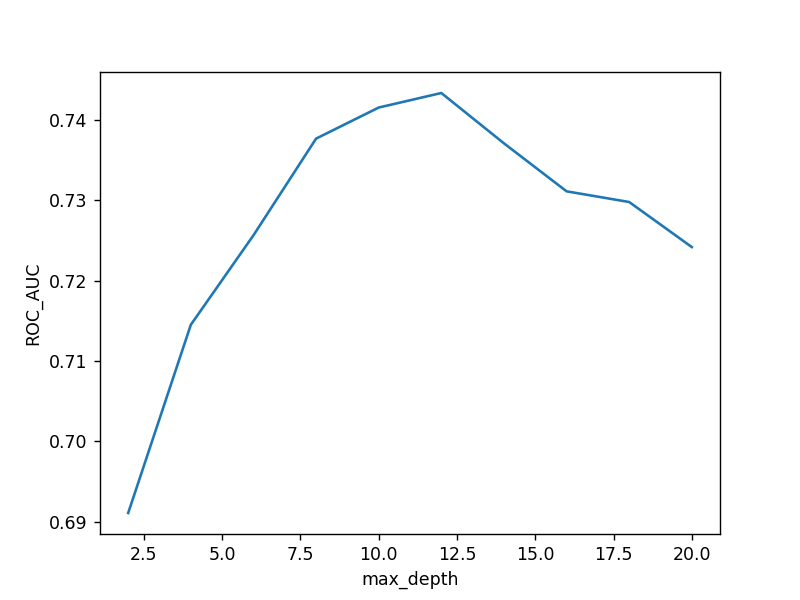

Text(0, 0.5, 'ROC_AUC')

In [35]:
ax = plt.figure('roc vs Tiempo Computo - max_depth')
plt.plot(max_depth,rocs2)
plt.xlabel('max_depth')
plt.ylabel('ROC_AUC')

<IPython.core.display.Javascript object>


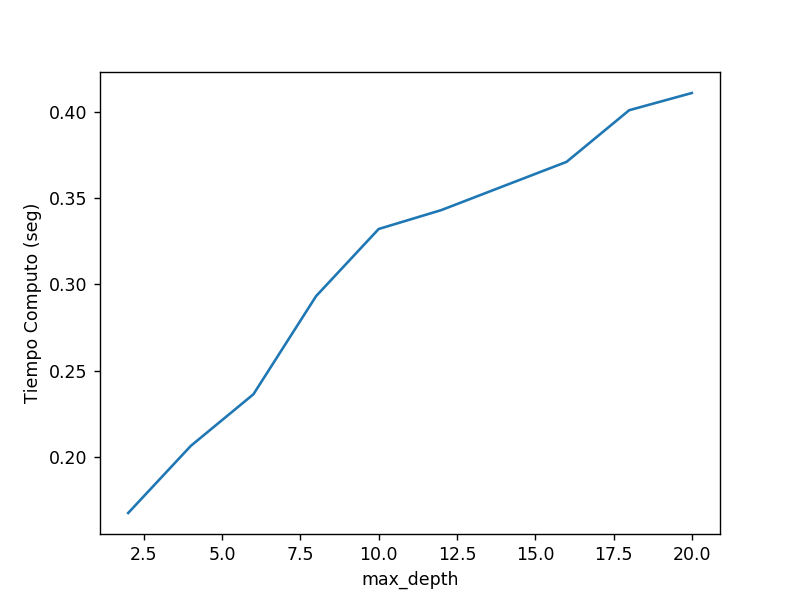

Text(0, 0.5, 'Tiempo Computo (seg)')

In [36]:
ax = plt.figure('max_depth vs Tiempo Computo')
plt.plot(max_depth,times2)
plt.xlabel('max_depth')
plt.ylabel('Tiempo Computo (seg)')